In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import pytorch_lightning as pl
from torchvision import datasets, transforms

import umap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

2025-08-13 06:24:24.244695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755066264.478935      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755066264.545754      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|██████████| 9.91M/9.91M [00:00<00:00, 55.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.61MB/s]


In [2]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.mlp1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        self.mlp2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = 1e-3

    def forward(self, x):
        a = self.mlp1(x)
        out = self.mlp2(a)
        return out, a

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits, _ = self(x)
        loss = self.loss_fn(logits, y)
        self.log("loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits, _ = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


model = CNN()
trainer = pl.Trainer(max_epochs=4, accelerator="auto", log_every_n_steps=10)

trainer.fit(model, train_loader, test_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [5]:
activations = []
labels = []
images = []
with torch.no_grad():
    for imgs, lbls in test_loader:
        _, feats = model(imgs)
        activations.append(feats)
        labels.append(lbls)
        images.append(imgs)

activations = torch.cat(activations).numpy()
labels = torch.cat(labels).numpy()
images = torch.cat(images)

In [6]:
activations.shape, labels.shape, images.shape

((10000, 64), (10000,), torch.Size([10000, 1, 28, 28]))

In [7]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42, n_jobs=1)
embedding = reducer.fit_transform(activations)

In [9]:
source, target = 8, 1
src_idx = np.where(labels == source)[0][0]
target_idx = np.where(labels == target)[0][0]

src_img = images[src_idx:src_idx+1]
adv_src_img = src_img.clone().detach().requires_grad_(True)

In [16]:
optimizer = optim.Adam([adv_src_img], lr=1e-3)
steps = 40
alphas = []
scenes = []

for step in tqdm(range(steps)):
    model.zero_grad()
    logits, _ = model(adv_src_img)
    loss = F.cross_entropy(logits, torch.tensor([target]))
    loss.backward()
    optimizer.step()

    perturb = torch.clamp(adv_src_img - src_img, -0.3, 0.3)
    adv_src_img.data = src_img + perturb
    adv_src_img.data = torch.clamp(adv_src_img, 0, 1)
    
    with torch.no_grad():
        _, a = model(adv_src_img)
    alphas.append(reducer.transform(a.numpy()))
    scenes.append(adv_src_img.detach().clone())

100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


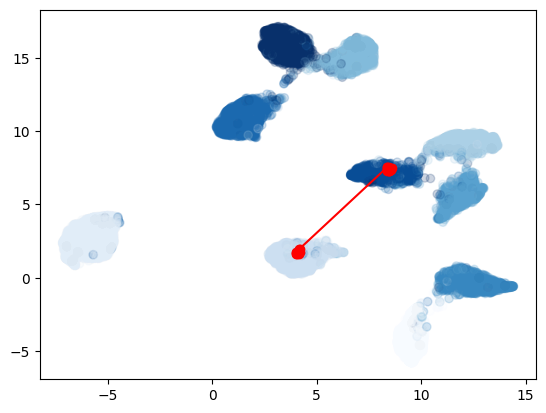

In [18]:
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=labels, cmap='Blues', alpha=0.2)
path_points = np.vstack(alphas)
plt.plot(path_points[:,0], path_points[:,1], color='red', marker='o')
plt.show()

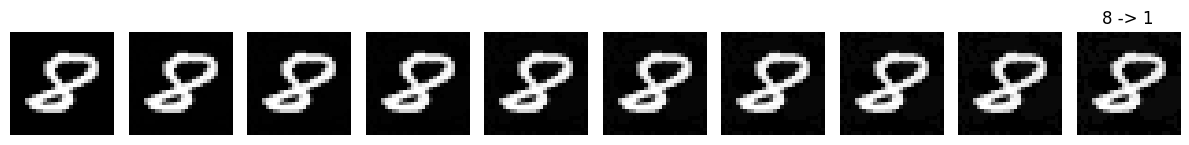

In [19]:
fig, axes = plt.subplots(1, len(scenes)//4, figsize=(12,2))
for i, ax in enumerate(axes):
    ax.imshow(scenes[i*4][0, 0].numpy(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.title(f"{source} -> {target}")
plt.show()